In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
import glob

import numpy as np
import pandas as pd
from scipy.signal import medfilt, find_peaks

import efmlib

In [3]:
show_plots = True

## Read data and make an initial plot so we can decide on launch

In [4]:
# Get sonde file
df_sonde = pd.read_csv('/data/LEE/Radiosonde_QC/LEENSSL1_pyqc20230706171936_20230201_180120.csv', parse_dates=['Time'])

#Get EFM files:
filenames = sorted(glob.glob('/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM*.TXT'))
df_gps, df_fiber = efmlib.io.read_efm_raw(filenames[:])

<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM00.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM01.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM02.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM03.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM04.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM05.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM06.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM07.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM08.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM09.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM10.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP10/IOP10_2007-11-2_sleet/EFM11.TXT'>.TXT
<_io.BufferedReader name='/data/LEE/IOP1

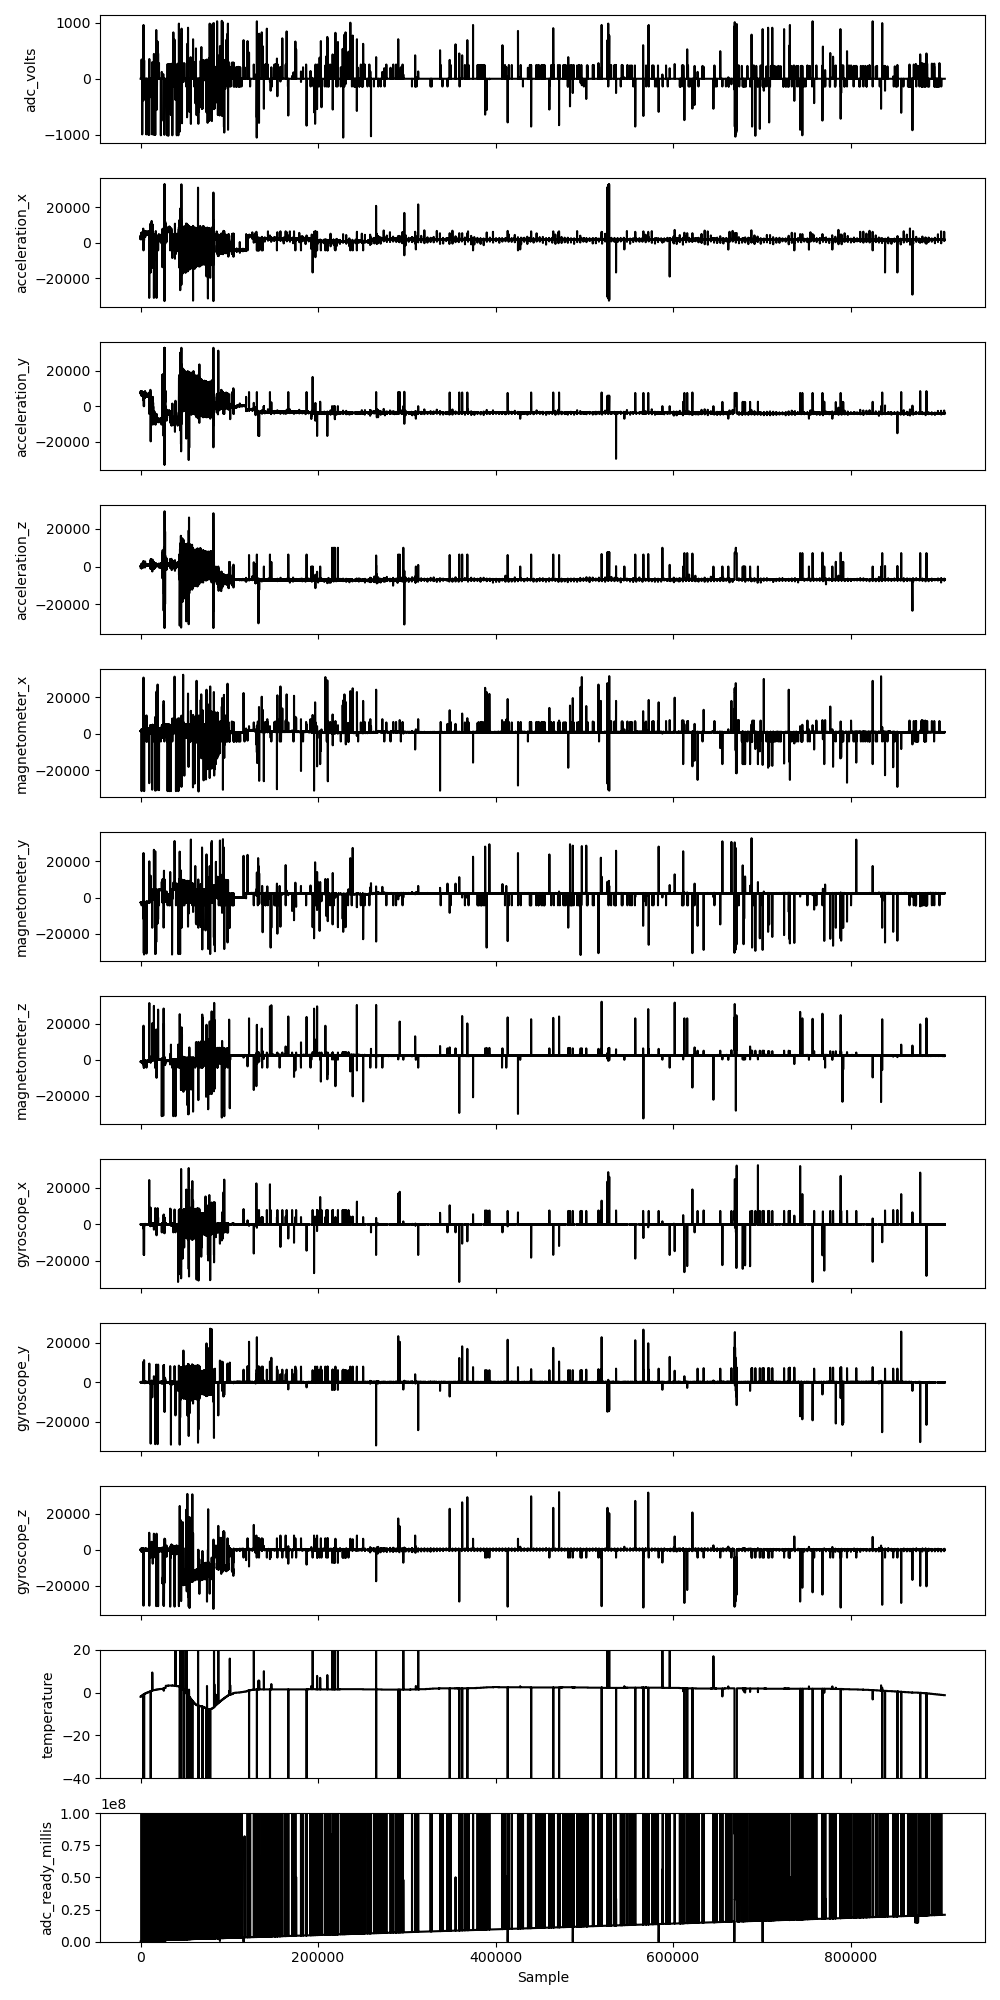

In [5]:
if show_plots == True:
    # print('-> Figures:')
    fields = ['adc_volts', 'acceleration_x', 'acceleration_y', 'acceleration_z',
              'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 
              'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 
              'temperature', 'adc_ready_millis']
    fig, axes = plt.subplots(figsize=(10, 20), nrows=len(fields), sharex=True)
    for fname, ax in zip(fields, axes):
        ax.plot(df_fiber[fname], color='k')
        ax.set_ylabel(fname)
    axes[-1].set_xlabel('Sample')
    fig.tight_layout()
    axes[-2].set_ylim(-40, 20)
    axes[-1].set_ylim(0, 1e8)

## Mark launch and do sample QC after that time

In [6]:
# Zoom into plot, look for a sudden increase in magnitude in the z-axis accelerometer and magnetomter.
launch_sample = 44593
end_trim = 105000

In [7]:
df_fiber = efmlib.qc.df_fiber_filter(df_fiber[launch_sample:end_trim].reset_index())                      #Quality control

Removing inserted junk data
indentifying sections that need reconstruction
removing excess samples from reconstructed regions
attempting to reconstruct regions with cosine functions
Removing outlier noise


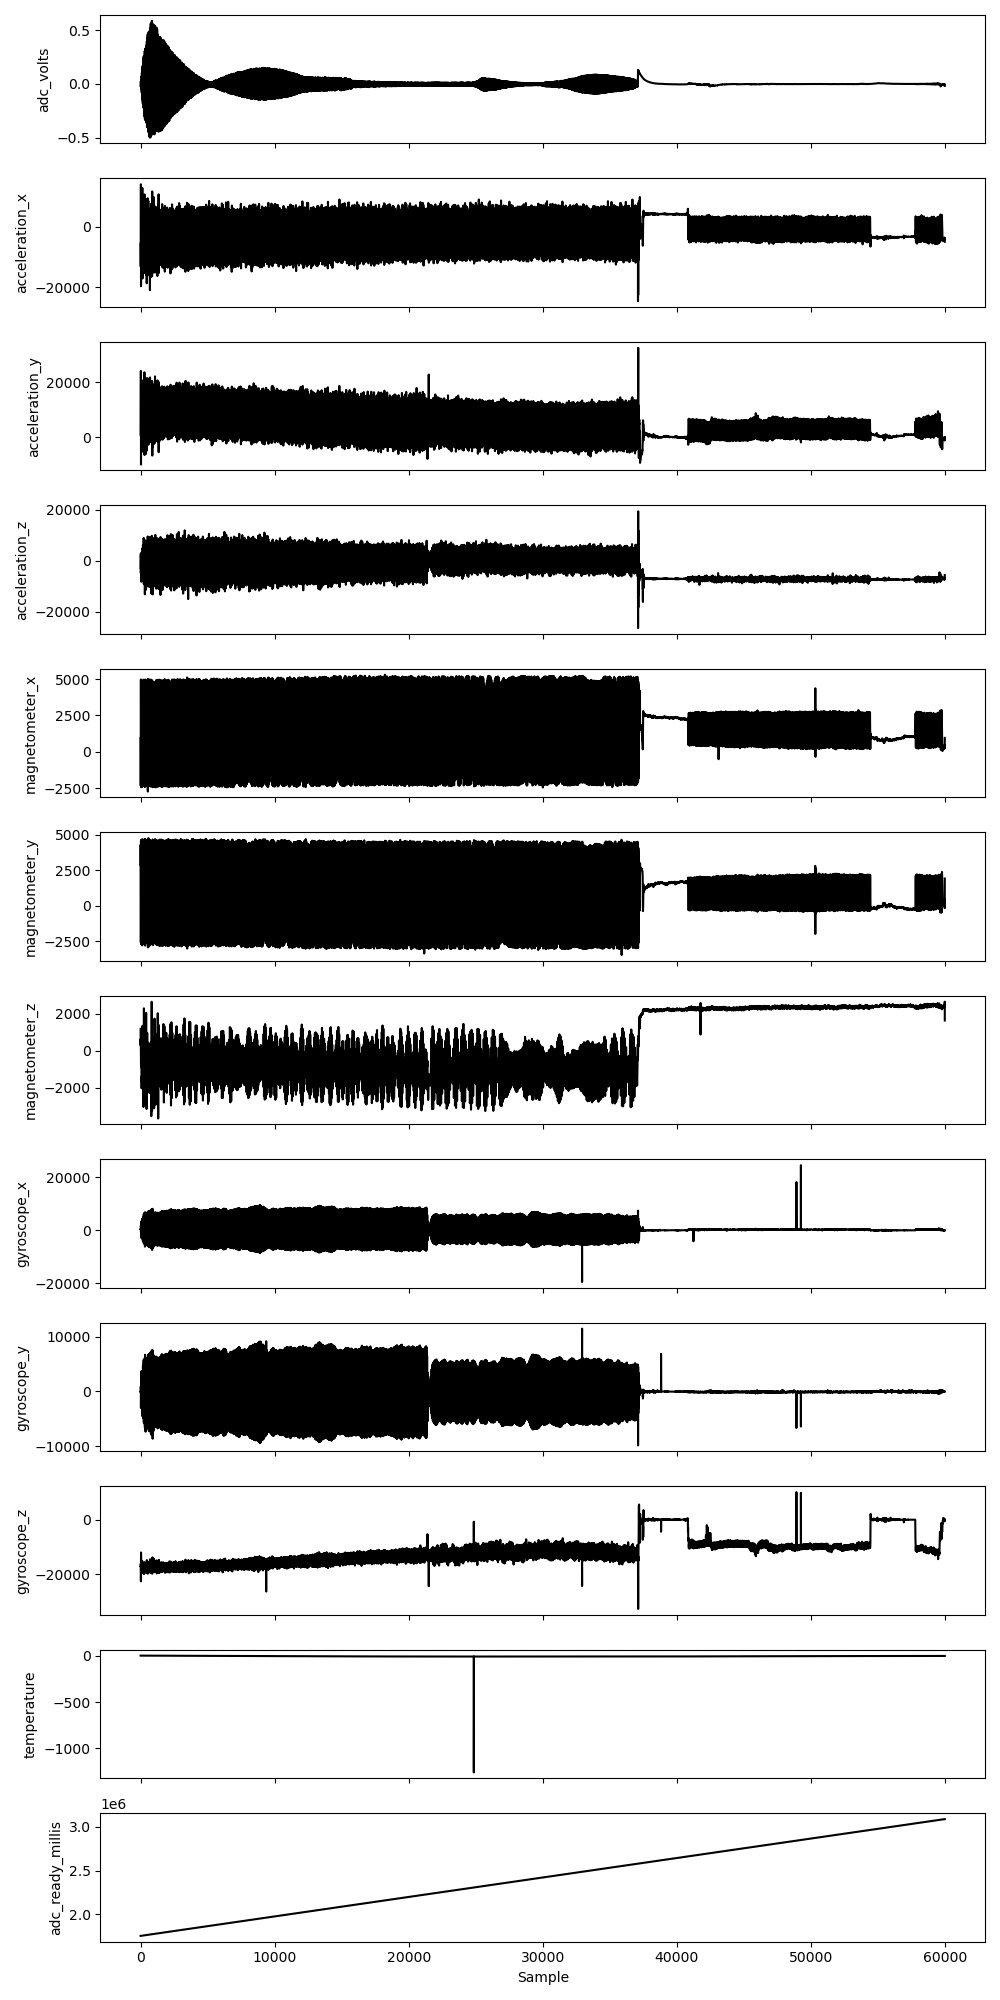

In [8]:
if show_plots == True:
    # print('-> Figures:')
    fields = ['adc_volts', 'acceleration_x', 'acceleration_y', 'acceleration_z',
              'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 
              'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 
              'temperature', 'adc_ready_millis']
    fig, axes = plt.subplots(figsize=(10, 20), nrows=len(fields), sharex=True)
    for fname, ax in zip(fields, axes):
        ax.plot(df_fiber[fname], color='k')
        ax.set_ylabel(fname)
    axes[-1].set_xlabel('Sample')
    fig.tight_layout()
    # axes[0].set_ylim(-1, 1)

In [9]:
# DRAFT: Bandpass filter the accelerometer signals, and then normalize by the total 
# length of the acceleration vector. Will naturally remove the centrifugal component, too. 
# For a quick hack at polarity, also bandpass filter the ADC signal the same way 
# as the acceleromter, then multiply and low pass filter to get a (hopefully slowly varying) polarity signal.

fs = 45.45
f_spin = efmlib.signal.freq_peak(df_fiber['acceleration_x'], fs)[0]
print("Spin rate from peak frequency is ", f_spin)

df_fiber, passband, bp_sos = efmlib.signal.normalize_accelerometer(df_fiber, fs=fs)
# Set the low pass cutoff at the same point as the lower end of the accelerometer passband. It's convenient.
lp_cut = passband[0]
adc_polarity_bp, lp_sos, adc_polarity, adc_sign = efmlib.signal.simplistic_E_polarity(df_fiber, bp_sos, lp_cut, fs=fs)


Spin rate from peak frequency is  0.004545151505050168


### Find peak-to-peak E and calibrate it

In [10]:
def find_peak_to_peak(adc, distance=9):
    peak_idx, peak_data         = find_peaks(adc, distance=distance)
    neg_peak_idx, neg_peak_data = find_peaks(-adc, distance=distance)
    n_peaks = min(peak_idx.shape[0], neg_peak_idx.shape[0])

    estimate_idxrange = 0, adc.shape[0]
    
    
    max_idx_critter = (peak_idx >= estimate_idxrange[0]) & (peak_idx < estimate_idxrange[1])
    min_idx_critter = (neg_peak_idx >= estimate_idxrange[0]) & (neg_peak_idx < estimate_idxrange[1])
    target_max_peak = peak_idx[max_idx_critter]
    target_min_peak = neg_peak_idx[min_idx_critter]
    peak_peak_range = (adc[target_max_peak]).max() - (adc[target_min_peak]).min()

    # This is a bad way to match up the peaks, since it assumes that there is an alternating set of positive
    # and negative peaks, instead of matching them by index.
    peak_peak_range = adc[peak_idx[:n_peaks]] - adc[neg_peak_idx[:n_peaks]]

    print('Number of peak samples:',peak_peak_range.shape[0])
    
    return peak_idx[:n_peaks], neg_peak_idx[:n_peaks], peak_peak_range

In [11]:
#Now extract peak voltages to separate array:
#------
# This is not ideal, but max of maxes minus min of mins is an ok estimate of the peak to peak voltage.

adc_samples = df_fiber['adc_volts'].values

peak_idx, neg_peak_idx, peak_peak_range = find_peak_to_peak(adc_samples)
E_calibrated_mag = efmlib.calibration.calibrated_E(peak_peak_range)

Number of peak samples: 2509


Displaying Peaks of raw voltage source (interpolated).


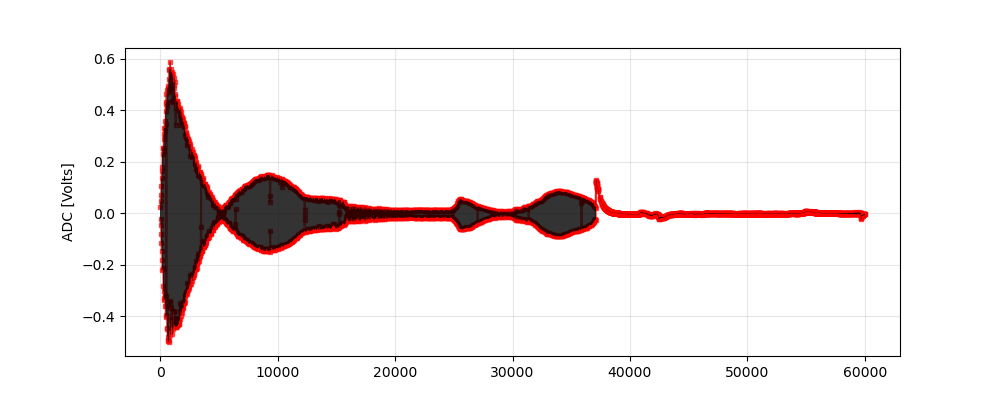

In [12]:
#Plot raw voltage signal with identified peaks (red)
#---------
print('Displaying Peaks of raw voltage source (interpolated).')
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(peak_idx, adc_samples[peak_idx], 
        color='r', marker='s', linewidth=None, markersize=3,alpha=0.6)
ax.plot(neg_peak_idx, adc_samples[neg_peak_idx], 
        color='r', marker='s', linewidth=None, markersize=3,alpha=0.6)

ax.plot(adc_samples, color='k', marker=None, linewidth=.2, markersize=2,alpha=0.8)
ax.set_ylabel('ADC [Volts]')
ax.grid(alpha=0.3)

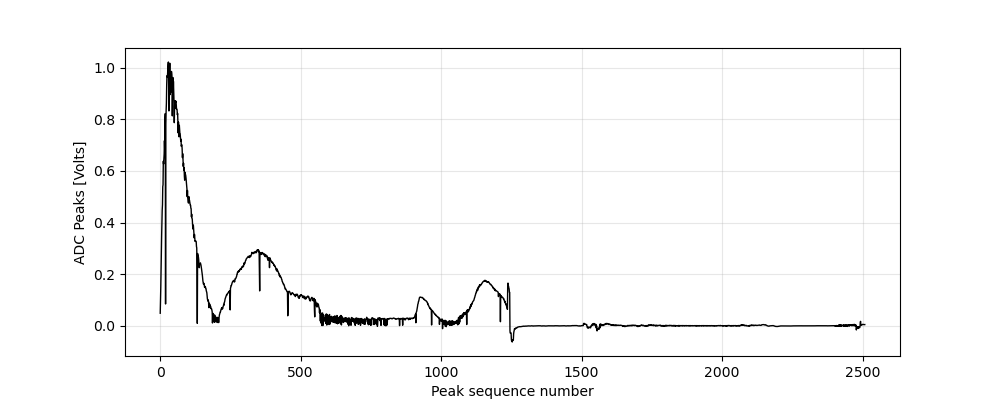

In [13]:
#Plot voltage peaks only:
#-------
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(peak_peak_range,color='k',linewidth=1)
ax.set_xlabel('Peak sequence number')
ax.set_ylabel('ADC Peaks [Volts]')
ax.grid(alpha=0.3)

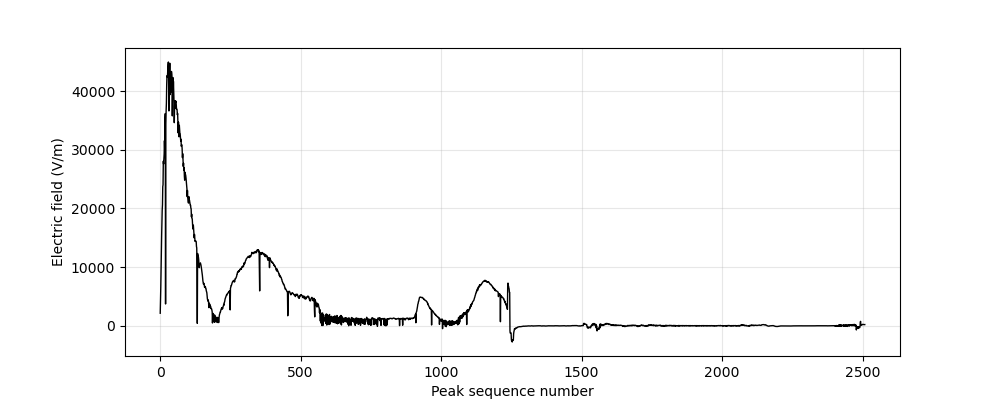

In [14]:
#Plot calibrated voltage to electric field signal:
#-------
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(E_calibrated_mag,color='k',linewidth=1)
ax.set_xlabel('Peak sequence number')
ax.set_ylabel('Electric field (V/m)')
ax.grid(alpha=0.3)

In [15]:
max_E = np.empty_like(adc_samples)*np.nan

# use the average of the peak indices as the representative sample for the peak-to-peak E.
max_E_idx = ((peak_idx+neg_peak_idx)/2.0).astype(int)

max_E[max_E_idx] = E_calibrated_mag

# Would be nice to LPF interpolate here before assigning back.
df_fiber['max_E'] = max_E*adc_sign

## Align EFM and sonde data

In [16]:
df_fiber.columns

Index(['index', 'start_byte', 'adc_ready_millis', 'adc_reading',
       'magnetometer_x', 'magnetometer_y', 'magnetometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'temperature', 'relative_humidity', 'pressure',
       'end_byte', 'adc_volts', 'acceleration_x_bp', 'acceleration_y_bp',
       'acceleration_z_bp', 'max_E'],
      dtype='object')

In [17]:
sonde_time_var = 'Time'
launch_time = df_sonde[sonde_time_var].values[0]
df_fiber[sonde_time_var]= launch_time + (df_fiber.adc_ready_millis - df_fiber.adc_ready_millis[0]).values.astype('timedelta64[ms]')

In [18]:
# Resample EFM data to 1 s
df_EFMsecond = df_fiber.set_index('Time').fillna(method='ffill').resample('1s').max()
df_merged = df_sonde.set_index('Time')
df_merged['max_E'] = df_EFMsecond.max_E

df_merged['T_C'] = df_merged['Filtered Temperature (K)'] - 273.15
df_merged['Td_C'] = df_merged['Filtered Dewpoint (K)'] - 273.15
df_merged['alt_km'] = df_merged['Filtered Altitude (m)']/1000.0

# df_merged

In [19]:
from scipy.ndimage import uniform_filter

E_smoothed = uniform_filter(df_merged.max_E, 5)

raw_charge_density = 8.854e-12*np.gradient(E_smoothed, df_merged.alt_km*1000)
charge_density_nCm3 = np.abs(
    uniform_filter(raw_charge_density * 1e9, 7)
)

(0.0, 2.0)

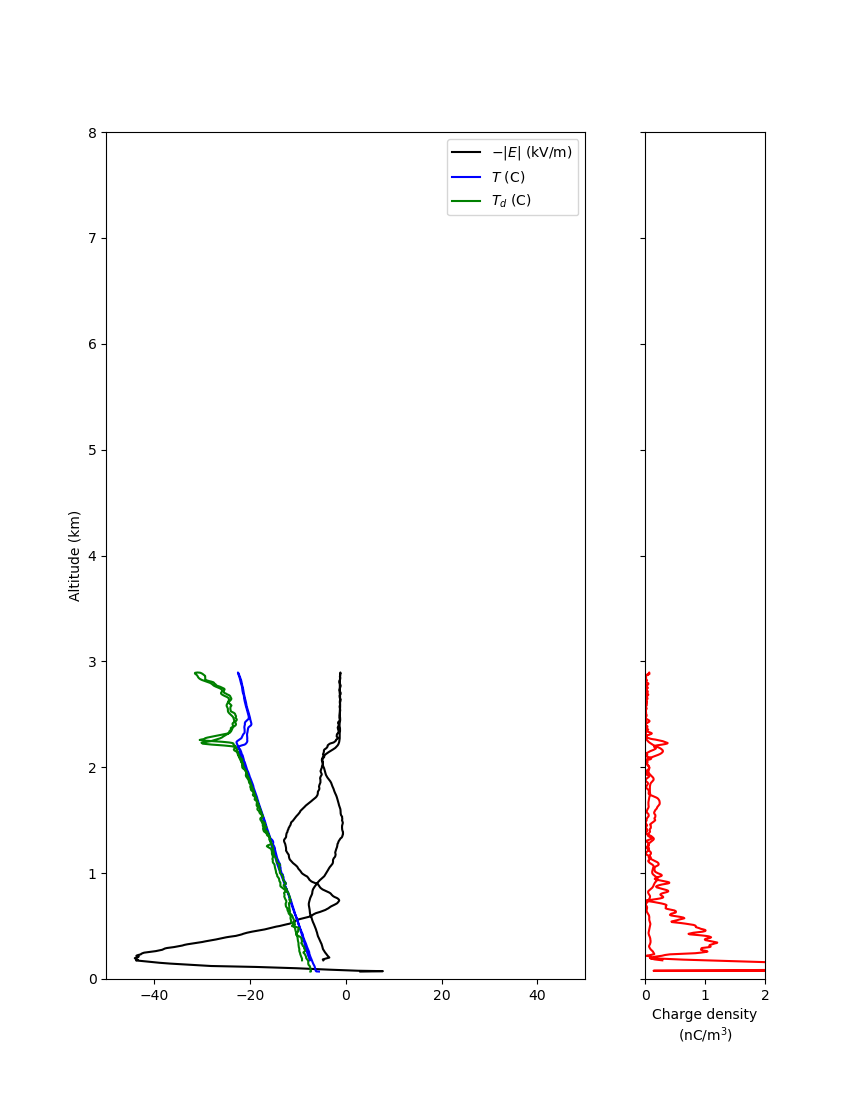

In [20]:
fig, (ax, ax_rho) = plt.subplots(1,2, figsize=(8.5, 11), 
                                 gridspec_kw={'width_ratios': [0.8, 0.2]}, sharey=True)
ax.plot(-E_smoothed/1000.0, df_merged.alt_km, color='k', label='$-|E|$ (kV/m)')
ax.plot(df_merged.T_C, df_merged.alt_km, color='b', label='$T$ (C)')
ax.plot(df_merged.Td_C, df_merged.alt_km, color='g', label='$T_d$ (C)')
ax.legend()
ax.set_xlim(-50,50)
ax.set_ylim(0, 8)
ax.set_ylabel('Altitude (km)')

ax_rho.plot(charge_density_nCm3, df_merged.alt_km, color='r')
ax_rho.set_xlabel('Charge density\n(nC/m$^3$)')
ax_rho.set_xlim(0,2)